In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# importing necessary libraries
import re
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from nltk.corpus import stopwords
import nltk

In [8]:
# download required NLTK data
nltk.download('stopwords', quiet=True)
STOP_WORDS = set(stopwords.words('english'))

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [w for w in text.split() if w not in STOP_WORDS]
    return " ".join(tokens)

In [9]:
# Load
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})
df['clean_review'] = df['review'].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'],
    df['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

In [10]:
# Pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid = {
    'tfidf__max_features': [5000, 10000],
    'clf__C': [0.5, 1.0, 2.0],
    'clf__penalty': ['l1', 'l2']
}

In [11]:
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [12]:
# Evaluation
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
cm   = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1       : {f1:.4f}")
print(f"Test AUC      : {auc:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative','Positive']))

Test Accuracy : 0.9001
Test Precision: 0.8967
Test Recall   : 0.9044
Test F1       : 0.9005
Test AUC      : 0.9641
Confusion Matrix:
[[4479  521]
 [ 478 4522]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5000
    Positive       0.90      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

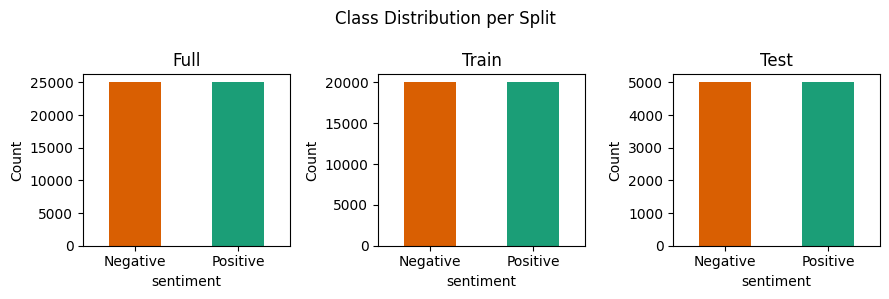

In [14]:
# Class distribution
fig, ax = plt.subplots(1, 3, figsize=(9,3))
splits = [(df, "Full"), (pd.DataFrame({'sentiment': y_train}), "Train"), (pd.DataFrame({'sentiment': y_test}), "Test")]
for a, (split_df, name) in zip(ax, splits):
    split_df['sentiment'].value_counts().sort_index().plot(
        kind='bar', ax=a, color=['#d95f02','#1b9e77'])
    a.set_title(name)
    a.set_xticklabels(['Negative','Positive'], rotation=0)
    a.set_ylabel('Count')
fig.suptitle('Class Distribution per Split', fontsize=12)
plt.tight_layout()
plt.show()

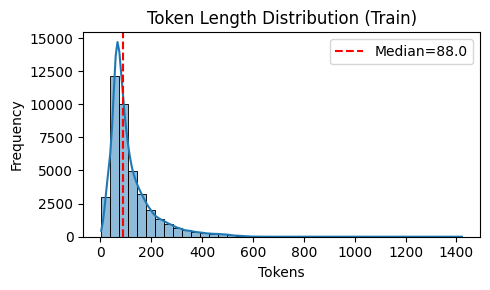

In [15]:
# Token length distribution
train_lengths = X_train.str.split().apply(len)
plt.figure(figsize=(5,3))
sns.histplot(train_lengths, bins=40, kde=True, color='#1f78b4')
plt.axvline(train_lengths.median(), color='red', linestyle='--',
            label=f"Median={train_lengths.median()}")
plt.title('Token Length Distribution (Train)')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

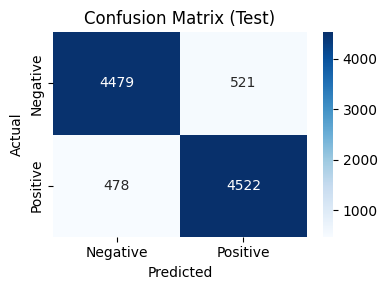

In [16]:
# Confusion Matrix
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()